In [1]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

#grafting/ acrage table
graft_df = pd.read_csv("graft.csv")

#production table
prod_df = pd.read_csv("production.csv")

#merge graft and production datasets 
df = prod_df.merge(graft_df)

#Make prod_wk datetime
df['prod_wk'] = pd.to_datetime(df['prod_wk'])

#Remove unneeded columns 
df = df.drop(['prod_date_cnt', 'prod_wk_no', 'min_date','max_date' ], axis=1)

#data cleaning
boxes = df['var_boxes']
acres = df['acres']

one_hot = pd.get_dummies(df['variety_desc'])

# Concatenate the one-hot encoded column with the original dataframe
df = pd.concat([df, one_hot], axis=1)

#create a new column for production yield (boxes per acre)
df['yield'] = boxes/acres 

#create a new column for age of the variety 
prod_yr = df['prod_yr'] 
graft_year = df['year_planted_grafted'] 
df['age'] = prod_yr - graft_year

#create a new column for yield classification: 
# High(2) : yield > 170  | Medium(1) : 170 > yield > 55   | Low(0) : yield < 55 
df['yield_class'] = df['yield'].apply(lambda x: 'high' if x > 175 else ('medium' if x >= 55  else 'low'))

num_high_yield = (df['yield_class'] == 'high').sum()
print(f"There are {num_high_yield} high yield values.")

num_med_yield = (df['yield_class'] == 'medium').sum()
print(f"There are {num_med_yield} medium yield values.")

num_low_yield = (df['yield_class'] == 'low').sum()
print(f"There are {num_low_yield} low yield values.")

There are 1232 high yield values.
There are 1660 medium yield values.
There are 1379 low yield values.


In [2]:
#rename
df = df.rename(columns={'prod_wk': 'date'})
df['color_code'] = pd.factorize(df['color'])[0]
df.head()
#GREEN  = 0 
#RED = 1
#BLACK = 2 
#NAN = -1
one_hot = pd.get_dummies(df['color'], prefix='color')
df = pd.concat([df, one_hot], axis=1)

one_hot2 = pd.get_dummies(df['ranch_no'], prefix = 'ranch')
df = pd.concat([df, one_hot2], axis=1)


df = df.rename(columns={'date': 'Date'})

#import weather and precipitation dataset
temps_df = pd.read_csv("temps.csv")

#drop unneeded columns 
temps_df = temps_df.drop(['Unnamed: 4', 'Unnamed: 5'], axis=1)

# convert the 'Date' column to datetime format
temps_df['Date'] = pd.to_datetime(temps_df['Date'])

# set the 'Date' column as the index
temps_df.set_index('Date', inplace=True)

# resample the data by week and calculate the mean of 'Daily_High'
weekly_avg = temps_df['Daily_High'].resample('W').mean()

#Make weekly_avg into a dataframe
weekly_avg = pd.DataFrame(weekly_avg)

#Add weekly_low_avg to weekly_avg
weekly_avg['weekly_low_avg'] =  temps_df['Daily _Low'].resample('W').mean()
#Add weekly_precipitation_avg to weekly_avg
weekly_avg['weekly_precipitation_avg'] =  temps_df['Precipitation '].resample('W').mean()
#Rename 'Daily_High' to 'weekly_high_avg'
weekly_avg = weekly_avg.rename(columns={'Daily_High': 'weekly_high_avg'})

temps_df.reset_index(inplace=True) 
temps_df.head()

merged_df = pd.merge(df, temps_df, on = 'Date', how='inner')
merged_df

,Date,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,color,prod_yr,grafted,acres,...,ranch_32,ranch_33,ranch_34,ranch_35,ranch_36,ranch_37,ranch_50,Daily_High,Daily _Low,Precipitation
0,2015-07-13,1,NaN,178,ARRA 15 - SWEETIES,3905,GREEN,2015,True,36.00,...,0,0,0,0,0,0,0,94,68,0.0
1,2015-07-13,14,NaN,16,ARRA 16,3038,GREEN,2015,True,8.00,...,0,0,0,0,0,0,0,94,68,0.0
2,2015-07-13,14,NaN,16,ARRA 16,3038,GREEN,2015,True,10.00,...,0,0,0,0,0,0,0,94,68,0.0
3,2015-07-13,29,SW,71,SUGRAONE,6389,GREEN,2015,True,18.00,...,0,0,0,0,0,0,0,94,68,0.0
4,2015-07-13,29,NW,71,SUGRAONE,23119,GREEN,2015,True,70.00,...,0,0,0,0,0,0,0,94,68,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,2018-11-12,32,NE,96,AUTUMN KING,23204,GREEN,2018,False,282.80,...,1,0,0,0,0,0,0,74,39,0.0
4263,2018-11-12,32,NW,755,ARRA 28 - ARRA PASSION PUNCH,667,RED,2018,True,69.35,...,1,0,0,0,0,0,0,74,39,0.0
4264,2019-07-01,33,W,90,EARLY SWEET,4155,GREEN,2019,False,63.00,...,0,1,0,0,0,0,0,93,65,0.0
4265,2019-07-01,33,W,90,EARLY SWEET,4155,GREEN,2019,True,35.00,...,0,1,0,0,0,0,0,93,65,0.0


In [3]:
#Drop unneccessary columns and rows with NAN and infinity values
#Dataset includes var_boxes and acres 
df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no',  'var_cd'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on='Date', how='inner')

#Split Date column into three columns - Year, Month, and Day
merged_df['year'] = merged_df['Date'].dt.year
merged_df['month'] = merged_df['Date'].dt.month
merged_df['day'] = merged_df['Date'].dt.day
merged_df = merged_df.drop('Date', axis=1)

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)

X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Create SVM model instance with a linear kernel
svm_model = LinearSVC()
# Train SVM model
svm_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = svm_model.predict(X_test)
# Evaluate model performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



Classification Report:
               precision    recall  f1-score   support

        high       0.84      0.97      0.90       380
         low       0.98      0.99      0.99       406
      medium       0.97      0.85      0.90       495

    accuracy                           0.93      1281
   macro avg       0.93      0.94      0.93      1281
weighted avg       0.93      0.93      0.93      1281



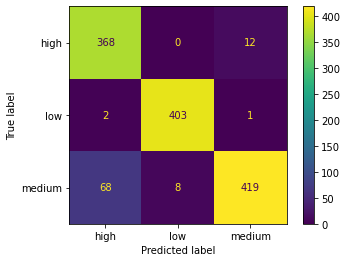

In [4]:
# Plot confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()

In [5]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(svm_model, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 0.86 (+/- 0.13)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [6]:
#Drop unneccessary columns and rows with NAN and infinity values
#Dataset includes var_boxes but NOT acres
df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no',  'var_cd', 'acres'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on='Date', how='inner')

#Split Date column into three columns - Year, Month, and Day
merged_df['year'] = merged_df['Date'].dt.year
merged_df['month'] = merged_df['Date'].dt.month
merged_df['day'] = merged_df['Date'].dt.day
merged_df = merged_df.drop('Date', axis=1)

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)

X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Create SVM model instance with a linear kernel
svm_model2 =  LinearSVC()
# Train SVM model
svm_model2.fit(X_train, y_train)
# Make predictions on the test set
y_pred = svm_model2.predict(X_test)
# Evaluate model performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00       380
         low       1.00      0.03      0.07       406
      medium       0.39      1.00      0.56       495

    accuracy                           0.40      1281
   macro avg       0.46      0.34      0.21      1281
weighted avg       0.47      0.40      0.24      1281



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labe

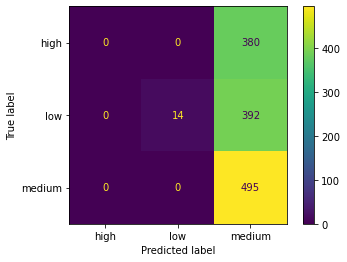

In [7]:
# Plot confusion matrix
plot_confusion_matrix(svm_model2, X_test, y_test)
plt.show()

In [8]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(svm_model2, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 0.42 (+/- 0.17)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [9]:
#Drop unneccessary columns and rows with NAN and infinity values
#Dataset includes NEITHER var_boxes or acres 

df2 = df.drop(['ranch_sub', 'prod_yr', 'color', 'yield', 'color_code','variety_desc', 'ranch_no',  'var_cd', 'var_boxes', 'acres'], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()

#merge weather dataset so production/graft datasets
merged_df = pd.merge(df2, temps_df, on='Date', how='inner')

#Split Date column into three columns - Year, Month, and Day
merged_df['year'] = merged_df['Date'].dt.year
merged_df['month'] = merged_df['Date'].dt.month
merged_df['day'] = merged_df['Date'].dt.day
merged_df = merged_df.drop('Date', axis=1)

yield_class = merged_df['yield_class']

#drop yield_class from dataset
merged_df = merged_df.drop(['yield_class'], axis = 1)

X, y = merged_df, yield_class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Create SVM model instance with a linear kernel
svm_model3 =  LinearSVC()
# Train SVM model
svm_model3.fit(X_train, y_train)
# Make predictions on the test set
y_pred = svm_model3.predict(X_test)
# Evaluate model performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        high       0.39      0.72      0.51       380
         low       0.42      0.58      0.48       406
      medium       0.36      0.01      0.02       495

    accuracy                           0.40      1281
   macro avg       0.39      0.44      0.34      1281
weighted avg       0.39      0.40      0.31      1281



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


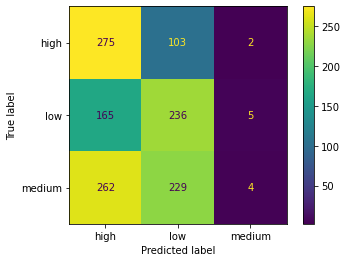

In [10]:
# Plot confusion matrix
plot_confusion_matrix(svm_model3, X_test, y_test)
plt.show()

In [11]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(svm_model3, X, y, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 0.40 (+/- 0.10)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
